<a href="https://colab.research.google.com/github/pjjongho/Colab_AD/blob/main/Abnormal%20Login.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 18**  
**┗ 이상 로그인 시도 감지**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「데이터 전처리 및 EDA」
* 🥈Session 2 - 「가설 수립 및 검증, 인사이트 발굴」
* 🥇Session 3 - 「이상 탐지 모델링」

# Prerequisites

$ pip install missingno, association-metrics

In [ ]:
location = 'local' # local에서 내려받아 실행시 'local'

In [ ]:
import warnings
import os
warnings.filterwarnings('ignore') # ▶ Warnings 제거

if location == 'colab' :
    from google.colab import drive
    drive.mount('/content/drive') # ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
    notebook_path = '/content/drive/MyDrive/Colab Notebooks' # ▶ 노트북 파일이 존재하는 경로 입력
    os.chdir(notebook_path)

# **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🧑💗 (개발자/데이터분석가)
```
A회사는 계정 해킹으로 인해 유저들에게 2,3차 피해가 발생할 것을 우려하고 있다.
과거 해킹으로 판명된 사례들과 다른 데이터를 활용해 해킹이 의심되는 로그인 시도가 발생할 경우 추가 인증등을 통하여 2,3차 피해를 막고자 한다.
```

> **데이터 살펴보기**

- 데이터로더 작성
- 파일 크기 약 9GB로 `pandas`로 처리시 비효율적이고 시간이 오래걸려 `dask` 활용
    1) 오래 기다리거나
    2) `dask`를 활용하여 분산 처리하여 실행 속도를 줄이거나
    3) 캐싱 활용하여 반복적인 작업에서 처리 시간 단축
    4) 샘플링하여 일부 데이터만 분석


- Dask 멀티프로세싱 (분산 처리) 설명

![](figures/18_3.png)


![](figures/18_2.png)

In [ ]:
!pip3 install dask

In [ ]:
from typing import Union
from pathlib import Path
import pandas as pd
import dask.dataframe as dd

class DataLoader:
    def __init__(self, data_path:Union[str, Path]):
        self.data_path = data_path
    def load_data(self) -> pd.DataFrame:
        return (
            dd.read_csv(self.data_path/'rba-dataset.csv')
        )

data_path = Path().cwd() / 'data' / 'chapter18'
data_loader = DataLoader(data_path=data_path)

In [ ]:
data = data_loader.load_data()

In [ ]:
data

Dask DataFrame Structure:
                 index Login Timestamp User ID Round-Trip Time [ms] IP Address Country  Region    City    ASN User Agent String Browser Name and Version OS Name and Version Device Type Login Successful Is Attack IP Is Account Takeover
npartitions=141                                                                                                                                                                                                                           
                 int64          object   int64              float64     object  object  object  object  int64            object                   object              object      object             bool         bool                bool
                   ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
...                ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
                   ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
                   ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
Dask Name: read-csv, 1 graph layer

In [ ]:
data.shape

(Delayed('int-98944290-83d0-4f93-9eaf-32b2084eaa25'), 16)

In [ ]:
!pip3 install dill


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


- 데이터 캐싱
    - pandas version 1.4.3에서 캐싱된 데이터이므로, 이외 버전으로 열었을 경우에 데이터 구조가 달라 열리지 않을 수 있음

In [ ]:
pd.__version__

'1.4.3'

In [ ]:
#!pip3 install pandas==1.4.3 --force-reinstall

In [ ]:
import dill

CACHE_PATH = Path().cwd() / 'data' / 'chapter18' / 'cache'
if not os.path.exists(CACHE_PATH) :
    os.mkdir(CACHE_PATH)

def save_pickle(data, filepath) :
    with open(filepath, 'wb') as f:
        dill.dump(data, f)
    return

def read_pickle(filepath):
    with open(filepath, 'rb') as f:
        data = dill.load(f)
    return data

CACHE_PATH

PosixPath('/home/FASTCAMPUS_2022/PART3/data/chapter18/cache')

In [ ]:
%%time

from typing import Tuple

def get_data_shape(data:pd.DataFrame) -> Tuple :
    data_shape_0 = (
        data
        .shape[0]
        .compute()
    )
    return (data_shape_0, data.shape[1])

filepath = CACHE_PATH / 'data_shape.pkl'

if os.path.exists(filepath) :
    data_shape = read_pickle(filepath)
else :
    data_shape = get_data_shape(data)
    save_pickle(data_shape, filepath)

CPU times: user 1.37 ms, sys: 3.31 ms, total: 4.67 ms
Wall time: 3.4 ms


In [ ]:
data_shape

(31269264, 16)

- Login fraud detection 이해

![](figures/18_1.png)

* Login attempt data (로그인 시도 데이터)
* 해킹 신고 접수된 계정에 대한 정보를 `Is Account Takeover` 컬럼으로 보유중
* 과거 공격에 사용되었던 IP에 대한 정보를 `Is Attack IP` 컬럼으로 보유중
* 데이터 명세 ⬇

In [ ]:
data_description_dict = {
    'index':'데이터 인덱스',
    'Login Timestamp':'로그인 시점',
    'User ID':'유저 ID',
    'Round-Trip Time [ms]':'클라이언트-서버간 지연시간',
    'IP Address':'IP 주소',
    'Country':'국가',
    'Region':'지역',
    'City':'도시',
    'ASN':'IP주소로부터 생성된 시스템넘버',
    'User Agent String':'유저 에이전트 정보',
    'Browser Name and Version':'브라우저 이름/버전',
    'OS Name and Version':'OS 이름/버전',
    'Device Type':'디바이스 타입',
    'Login Successful':'로그인 성공',
    'Is Attack IP':'의심 IP',
    'Is Account Takeover':'해킹된 계정',
}

(
    data
    .head()
    .append(
        data_description_dict,
        ignore_index=True
    )
    .iloc[[-1, 0]]
    .T
    .rename(columns={5:'데이터 설명', 0:'샘플 데이터'})
)

데이터 설명  \
index                               데이터 인덱스   
Login Timestamp                      로그인 시점   
User ID                               유저 ID   
Round-Trip Time [ms]         클라이언트-서버간 지연시간   
IP Address                            IP 주소   
Country                                  국가   
Region                                   지역   
City                                     도시   
ASN                       IP주소로부터 생성된 시스템넘버   
User Agent String                유저 에이전트 정보   
Browser Name and Version         브라우저 이름/버전   
OS Name and Version                OS 이름/버전   
Device Type                         디바이스 타입   
Login Successful                     로그인 성공   
Is Attack IP                          의심 IP   
Is Account Takeover                  해킹된 계정   

                                                                     샘플 데이터  
index                                                                     0  
Login Timestamp                                     2020-02-03 12:43:30.772  
User ID                                                -4324475583306591935  
Round-Trip Time [ms]                                                    NaN  
IP Address                                                      10.0.65.171  
Country                                                                  NO  
Region                                                                    -  
City                                                                      -  
ASN                                                                   29695  
User Agent String         Mozilla/5.0  (iPhone; CPU iPhone OS 13_4 like ...  
Browser Name and Version                                Firefox 20.0.0.1618  
OS Name and Version                                                iOS 13.4  
Device Type                                                          mobile  
Login Successful                                                      False  
Is Attack IP                                                          False  
Is Account Takeover                                                   False


# **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 과거 계정 탈취/공격 데이터로부터 미래의 계정 탈취/공격을 방어할수 있는 모델 개발
```  

> **기대효과**

```
▶ 해킹으로 인한 2,3차 피해 방지
```

> **해결방안**

```
▶ 과거 사고 데이터를 바탕으로 비정상 접근 탐지 모델을 개발
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 가설 수립 및 검증, 인사이트 발굴
▶ Session 3 🥇
 - 이상 탐지 모델링
```

> **성과측정**  

```
▶ 이상 접근 탐지율
```

> **현업적용**  

```
▶ Model에 Input하기 위한 Data mart 생성
▶ 예측 모델 활용을 위한 사고 데이터 수집
```


# **🥉Session 1**  
**┗ 데이터 전처리 및 EDA**  
---

### · Data 이해
---
* 수집된 데이터의 기본 정보들을 확인  

#### (1) Data shape(형태) 확인
- 얼마나 많은 Record(row)가 있는지, 사용할 수 있는 Feature(column)의 수가 얼마나 되는지 확인



In [ ]:
data_shape

(31269264, 16)

#### (2) Data type 확인
- Categorical, numerical feature가 얼마나 있는지 확인

In [ ]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, index to Is Account Takeover
dtypes: object(9), bool(3), float64(1), int64(3)

In [ ]:
data

Dask DataFrame Structure:
                 index Login Timestamp User ID Round-Trip Time [ms] IP Address Country  Region    City    ASN User Agent String Browser Name and Version OS Name and Version Device Type Login Successful Is Attack IP Is Account Takeover
npartitions=141                                                                                                                                                                                                                           
                 int64          object   int64              float64     object  object  object  object  int64            object                   object              object      object             bool         bool                bool
                   ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
...                ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
                   ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
                   ...             ...     ...                  ...        ...     ...     ...     ...    ...               ...                      ...                 ...         ...              ...          ...                 ...
Dask Name: read-csv, 1 graph layer

#### (3) Null값 확인 (※ 빈 값의 Data)
- 빈 값이 있을 경우 모델에서 Null값을 핸들링해주는지 확인
- 또는 Imputation을 통해 빈 값을 채워주거나
- Imputation이 어려울 경우 해당 Row를 제거하는 방법도 고려하여야 함

In [ ]:
data.isna()

Dask DataFrame Structure:
                index Login Timestamp User ID Round-Trip Time [ms] IP Address Country Region  City   ASN User Agent String Browser Name and Version OS Name and Version Device Type Login Successful Is Attack IP Is Account Takeover
npartitions=141                                                                                                                                                                                                                      
                 bool            bool    bool                 bool       bool    bool   bool  bool  bool              bool                     bool                bool        bool             bool         bool                bool
                  ...             ...     ...                  ...        ...     ...    ...   ...   ...               ...                      ...                 ...         ...              ...          ...                 ...
...               ...             ...     ...                  ...        ...     ...    ...   ...   ...               ...                      ...                 ...         ...              ...          ...                 ...
                  ...             ...     ...                  ...        ...     ...    ...   ...   ...               ...                      ...                 ...         ...              ...          ...                 ...
                  ...             ...     ...                  ...        ...     ...    ...   ...   ...               ...                      ...                 ...         ...              ...          ...                 ...
Dask Name: isna, 2 graph layers

In [ ]:
%%time

filepath = CACHE_PATH / 'data_nan_sum.pkl'

if os.path.exists(filepath) :
    data_nan_sum = read_pickle(filepath)
else :
    data_nan_sum = (
        data
        .isna()
        .sum()
        .compute()
    )
    save_pickle(data_nan_sum, filepath)

CPU times: user 3.55 ms, sys: 1.34 ms, total: 4.9 ms
Wall time: 2.5 ms


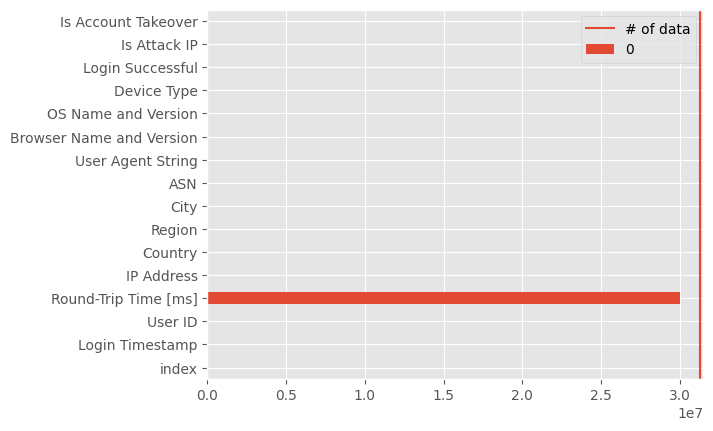

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

(
    data_nan_sum
    .to_frame()
    .plot(kind='barh')
)
plt.axvline(data_shape[0], label='# of data')
plt.legend()

#### (4) # of unique values, data distribution, outlier 확인 (※ 정상적인 범주를 벗어난 Data)

- number of unique values : 예측에 사용할 수 있는 유의미한 정보를 담은 Column인지, 단순 ID 등의 의미없는 Column인지 확인
- Distribution : 학습에 방해가 될 수 있는 불균형한 데이터셋인지 확인. Label이 Imbalanced한 경우 Novelty dectection 등의 모델을 고려하여야 함
- Outlier 확인 : 모델 학습에 방해가 될 수 있는 Outlier 등이 존재하는지 확인


In [ ]:
%%time

filepath = CACHE_PATH / 'data_number_of_unique_values.pkl'

if os.path.exists(filepath) :
    data_number_of_unique_values = read_pickle(filepath)
else :
    data_number_of_unique_values = (
        data
        .nunique()
        .compute()
        .to_frame()
        .reset_index()
        .rename(columns={'index':'column_name', 0:'number_of_unique_values'})
        .assign(data_shape=data_shape[0])
    )
    save_pickle(data_number_of_unique_values, filepath)

CPU times: user 3.01 ms, sys: 254 µs, total: 3.26 ms
Wall time: 3.22 ms


In [ ]:
data_number_of_unique_values

column_name  number_of_unique_values  data_shape
0                      index                 31269264    31269264
1            Login Timestamp                 31269085    31269264
2                    User ID                  4304857    31269264
3       Round-Trip Time [ms]                     9113    31269264
4                 IP Address                  3512330    31269264
5                    Country                      229    31269264
6                     Region                     2638    31269264
7                       City                    38885    31269264
8                        ASN                    12955    31269264
9          User Agent String                   420952    31269264
10  Browser Name and Version                     4549    31269264
11       OS Name and Version                      653    31269264
12               Device Type                        5    31269264
13          Login Successful                        2    31269264
14              Is Attack IP                        2    31269264
15       Is Account Takeover                        2    31269264

In [ ]:
%%time

column = 'Is Attack IP'
filepath = CACHE_PATH / f'data_value_counts_{column}.pkl'

if os.path.exists(filepath) :
    data_toplot = read_pickle(filepath)
else :
    data_toplot = (
        data
        [column]
        .value_counts()
        .compute()
    )
    save_pickle(data_toplot, filepath)

CPU times: user 1.09 ms, sys: 2.28 ms, total: 3.37 ms
Wall time: 2.54 ms


Text(0.5, 1.0, 'Is Attack IP')

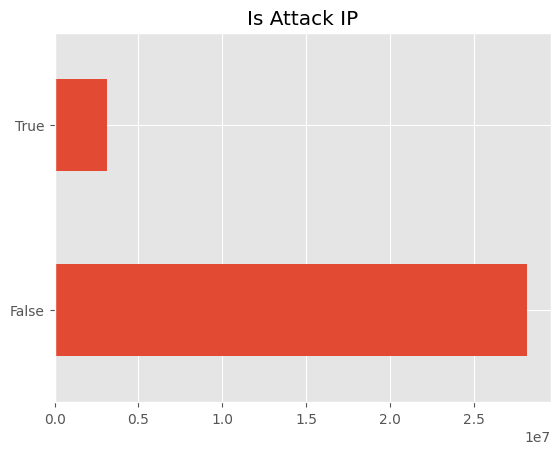

In [ ]:
(
    data_toplot
    .plot(kind='barh')
)
plt.title(column)

In [ ]:
%%time

column = 'Is Account Takeover'
filepath = CACHE_PATH / f'data_value_counts_{column}.pkl'

if os.path.exists(filepath) :
    data_toplot = read_pickle(filepath)
else :
    data_toplot = (
        data
        [column]
        .value_counts()
        .compute()
    )
    save_pickle(data_toplot, filepath)

CPU times: user 8.97 ms, sys: 198 µs, total: 9.17 ms
Wall time: 3.1 ms


Text(0.5, 1.0, 'Is Account Takeover')

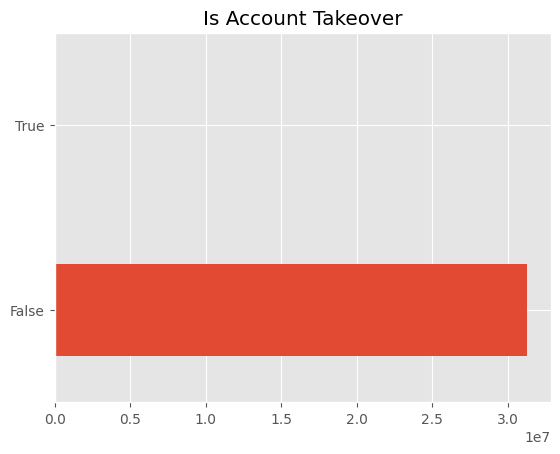

In [ ]:
(
    data_toplot
    .plot(kind='barh')
)
plt.title(column)

In [ ]:
(
    data_toplot
    .to_frame()
)

Is Account Takeover
False             31269123
True                   141

### · EDA로부터 얻은 인사이트
---
#### (1) 피쳐 수 적음, 데이터 Row 많음
#### (2) 한개 컬럼이 대부분 결측치이고, 나머지는 결측치 존재하나 그 양은 적음
#### (3) 동일 ID에 대해 여러번의 접속 시도가 존재하는 데이터
#### (4) User agent, browser, os 등 원 형태 그대로는 활용하기 어려운 데이터가 있어 추가 처리 필요

# **🥈Session 2**  
**┗ 가설 수립 및 검증, 인사이트 발굴**  
---

### · 가설 수립
- EDA : 데이터를 보고 떠올리거나
- 문헌조사 : 관련 논문, 업계 리포트, 뉴스 등을 참조하거나
- 인터뷰 : 관련 부서 담당자분들께 아이디어를 얻음
---
#### (1) 해킹 의심 계정과 일반 계정 사용 패턴 비교
#### (2) 접속 빈도와 해킹 의심 계정 관의 연관성 추적

### · 가설 검증 및 인사이트 발굴
---

#### (1) 해킹 의심 계정과 일반 계정 사용 패턴 비교

In [ ]:
%%time

column = 'Is Account Takeover'
is_true = True
filepath = CACHE_PATH / f'data_{column}_{is_true}_head.pkl'

if os.path.exists(filepath) :
    data_sample = read_pickle(filepath)
else :
    data_sample = (
        data
        .loc[lambda x : x['Is Account Takeover']==True]
        .head()
    )
    save_pickle(data_sample, filepath)

CPU times: user 7.13 ms, sys: 1.05 ms, total: 8.18 ms
Wall time: 3.59 ms


In [ ]:
data_sample

index          Login Timestamp              User ID  \
82873    82873  2020-02-04 13:45:50.280  5519106287451092780   
82947    82947  2020-02-04 13:46:45.241 -7654599524478640403   
100085  100085  2020-02-04 17:15:42.743 -6380256063165146454   
202905  202905  2020-02-06 05:19:28.841  4130074439166519892   

        Round-Trip Time [ms]     IP Address Country                Region  \
82873                    NaN     10.4.1.162      IT  Provincia di Treviso   
82947                    NaN     10.4.1.162      IT  Provincia di Treviso   
100085                   NaN   31.131.16.24      RO                     -   
202905                   NaN  185.170.136.4      IT                Veneto   

             City     ASN                                  User Agent String  \
82873     Treviso  503109  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
82947     Treviso  503109  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
100085          -   56851  Mozilla/5.0  (X11; CrOS armv7l 5978.98.0) Appl...   
202905  Sospirolo  206801  Mozilla/5.0  (iPad; CPU OS 8_2 like Mac OS X) ...   

        Browser Name and Version  OS Name and Version Device Type  \
82873   Chrome 79.0.3945.192.218     Mac OS X 10.14.6     desktop   
82947   Chrome 79.0.3945.192.218     Mac OS X 10.14.6     desktop   
100085    Chrome 71.0.3578.40.50  Chrome OS 5978.98.0     desktop   
202905             Android 2.3.6              iOS 8.2      mobile   

        Login Successful  Is Attack IP  Is Account Takeover  
82873               True         False                 True  
82947               True         False                 True  
100085              True          True                 True  
202905              True         False                 True

In [ ]:
%%time

from tqdm import tqdm

user_ids_account_taken = [
    5519106287451092780,
    -7654599524478640403,
]

user_ids_account_not_taken = [
    -3284137479262433373,
    -4618854071942621186,
]

filepath = CACHE_PATH / f'data_account_samples.pkl'

if os.path.exists(filepath) :
    data_accounts = read_pickle(filepath)
else :
    data_accounts = {}

    for user_id in tqdm(user_ids_account_taken + user_ids_account_not_taken) :
        data_accounts[user_id] = (
            data
            .loc[lambda x : x['User ID']==user_id]
            .compute()
        )
    save_pickle(data_accounts, filepath)

CPU times: user 12.8 ms, sys: 3.49 ms, total: 16.3 ms
Wall time: 6.45 ms


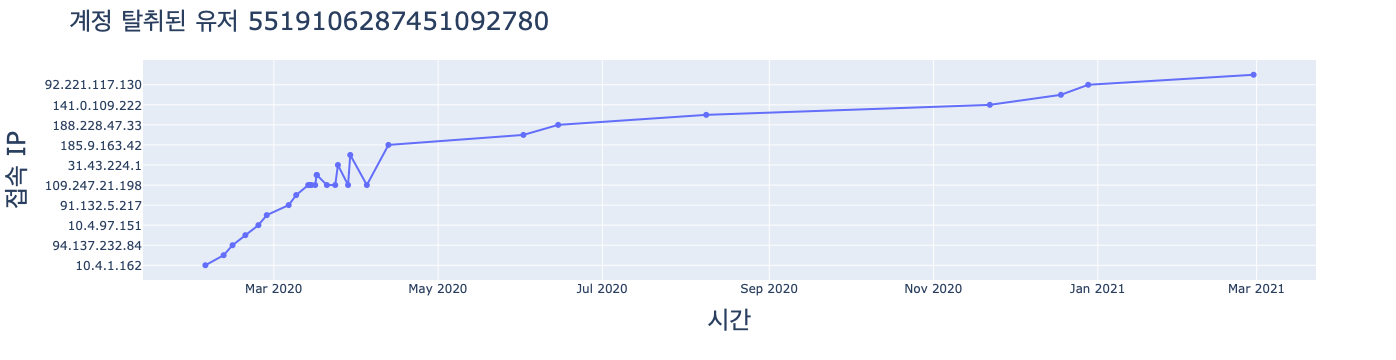

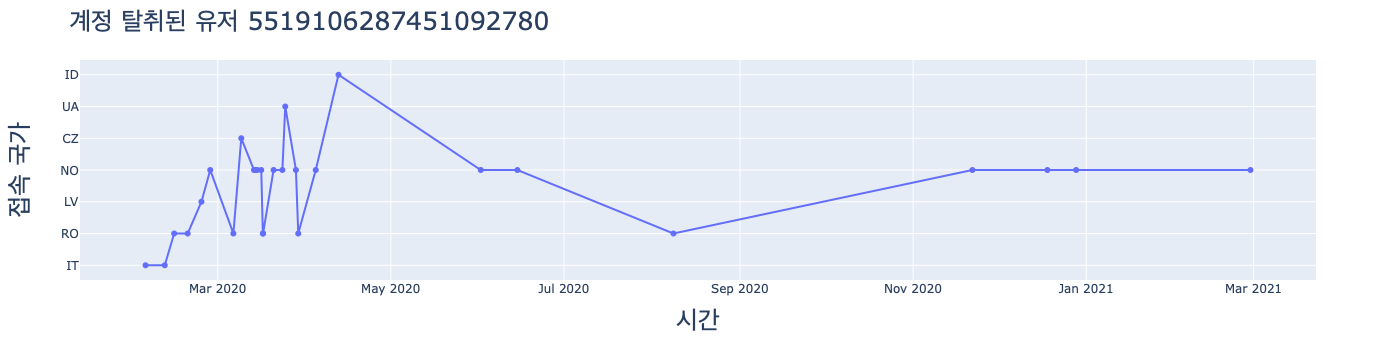

Login Timestamp       IP Address Country  Is Attack IP  \
82873  2020-02-04 13:45:50.280       10.4.1.162      IT         False   
151032 2020-02-11 08:08:27.314    5.180.170.225      IT          True   
211237 2020-02-14 15:43:52.133    94.137.232.84      RO          True   
139180 2020-02-19 10:05:48.460      10.4.93.138      RO         False   
60642  2020-02-24 06:17:12.091      10.4.97.151      LV         False   
88224  2020-02-27 08:43:09.716  193.150.121.220      NO          True   
62073  2020-03-06 12:21:25.897     91.132.5.217      RO          True   
18824  2020-03-09 07:11:32.216      31.133.8.14      CZ         False   
132512 2020-03-13 18:28:50.272   109.247.21.198      NO         False   
171822 2020-03-14 12:36:14.220   109.247.21.198      NO         False   
174865 2020-03-14 13:25:52.812   109.247.21.198      NO         False   
175487 2020-03-14 13:34:45.473   109.247.21.198      NO         False   
200638 2020-03-14 20:53:01.289   109.247.21.198      NO         False   
68637  2020-03-16 08:07:08.562   109.247.21.198      NO         False   
126325 2020-03-16 21:39:25.663   91.240.236.148      RO          True   
128968 2020-03-16 23:21:44.713   91.240.236.148      RO          True   
186226 2020-03-20 16:14:27.066   109.247.21.198      NO         False   
187874 2020-03-23 18:51:21.249   109.247.21.198      NO         False   
50345  2020-03-24 19:01:14.758      31.43.224.1      UA         False   
102000 2020-03-28 13:22:08.718   109.247.21.198      NO         False   
152069 2020-03-29 08:52:15.719    85.204.116.33      RO          True   
209022 2020-04-04 12:48:40.418   109.247.21.198      NO         False   
119616 2020-04-12 13:19:53.529     185.9.163.42      ID         False   
31123  2020-06-01 16:10:11.794   156.52.253.193      NO         False   
56760  2020-06-14 14:01:06.823    188.228.47.33      NO         False   
104098 2020-08-08 13:37:29.009     5.180.170.56      RO          True   
176293 2020-11-21 21:31:38.217    141.0.109.222      NO         False   
28714  2020-12-18 07:10:26.552  158.248.241.242      NO         False   
159963 2020-12-28 10:21:38.688   92.221.117.130      NO         False   
143419 2021-02-27 20:28:36.845       10.0.58.58      NO         False   

        Is Account Takeover  \
82873                  True   
151032                False   
211237                False   
139180                False   
60642                 False   
88224                 False   
62073                 False   
18824                 False   
132512                False   
171822                False   
174865                False   
175487                False   
200638                False   
68637                 False   
126325                False   
128968                False   
186226                False   
187874                False   
50345                 False   
102000                False   
152069                False   
209022                False   
119616                False   
31123                 False   
56760                 False   
104098                False   
176293                False   
28714                 False   
159963                False   
143419                False   

                                        User Agent String  \
82873   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
151032  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
211237  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
139180  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
60642   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
88224   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
62073   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
18824   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
132512  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   
171822  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   
174865  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   
175487  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...

In [ ]:
import plotly.express as px

user_id = user_ids_account_taken[0]

data_toplot = (
    data_accounts[user_id]
    .assign(**{'Login Timestamp':lambda x : pd.to_datetime(x['Login Timestamp'])})
    .assign(**{'IP Address':lambda x : x['IP Address'].astype(str)})
)
fig = px.line(
    data_toplot,
    x='Login Timestamp',
    y='IP Address',
    markers=True
)
fig.update_layout(
    title=dict(
        text=f'계정 탈취된 유저 {user_id}',
        font=dict(size=25),
    ),
    xaxis_title=dict(
        text="시간",
        font=dict(size=25),
    ),
    yaxis_title=dict(
        text="접속 IP",
        font=dict(size=25),
    ),
)
fig.show()

fig = px.line(
    data_toplot,
    x='Login Timestamp',
    y='Country',
    markers=True
)
fig.update_layout(
    title=dict(
        text=f'계정 탈취된 유저 {user_id}',
        font=dict(size=25),
    ),
    xaxis_title=dict(
        text="시간",
        font=dict(size=25),
    ),
    yaxis_title=dict(
        text="접속 국가",
        font=dict(size=25),
    ),
)
fig.show()

display(
    data_toplot
    .loc[:, ['Login Timestamp',
             'IP Address',
             'Country',
             'Is Attack IP',
             'Is Account Takeover',
             'User Agent String',
             'Browser Name and Version',
             'OS Name and Version',
            ]
        ]
)

del(data_toplot)

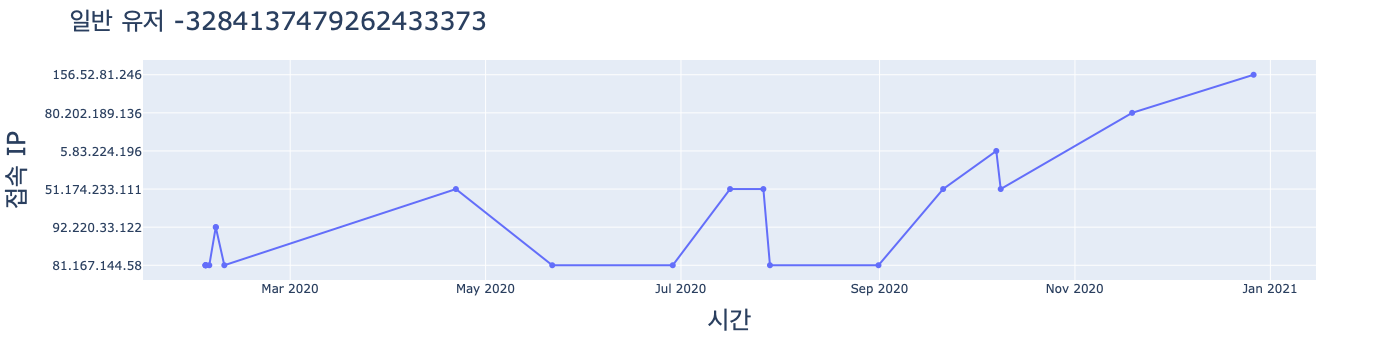

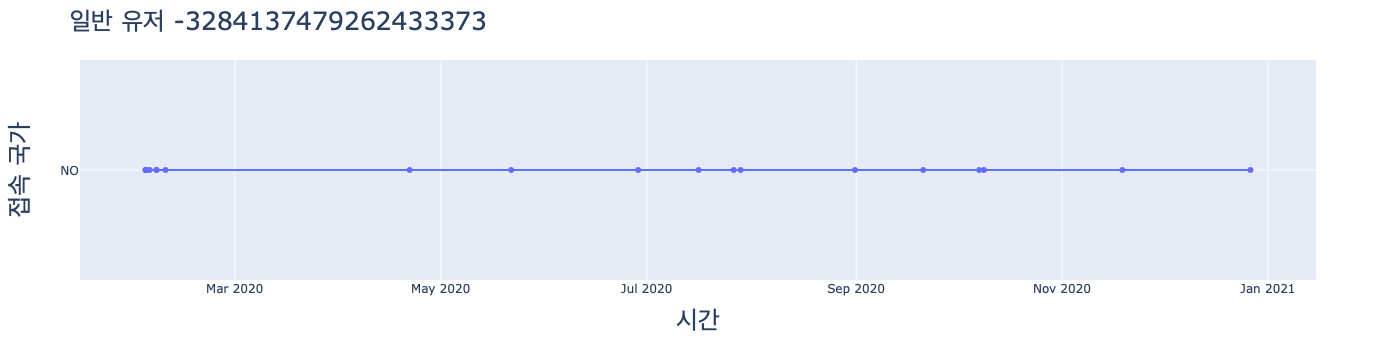

Login Timestamp      IP Address Country  Is Attack IP  \
2      2020-02-03 12:43:55.873   81.167.144.58      NO         False   
209    2020-02-03 12:47:09.768   81.167.144.58      NO         False   
15924  2020-02-03 15:52:18.667   81.167.144.58      NO         False   
16053  2020-02-03 15:53:39.368   81.167.144.58      NO         False   
103119 2020-02-04 17:54:18.658   81.167.144.58      NO         False   
41949  2020-02-06 18:19:32.480   92.220.33.122      NO         False   
46675  2020-02-06 19:24:18.909   92.220.33.122      NO         False   
211390 2020-02-09 10:31:44.369   81.167.144.58      NO         False   
154060 2020-04-21 17:31:10.195  51.174.233.111      NO         False   
186057 2020-05-21 19:27:35.004   81.167.144.58      NO         False   
216905 2020-06-28 10:22:35.185   81.167.144.58      NO         False   
23893  2020-07-16 07:50:19.419  51.174.233.111      NO         False   
112608 2020-07-26 17:24:11.574  51.174.233.111      NO         False   
48186  2020-07-28 18:39:53.380   81.167.144.58      NO         False   
9947   2020-08-31 15:54:24.582   81.167.144.58      NO         False   
164405 2020-09-20 20:23:13.795  51.174.233.111      NO         False   
60213  2020-10-07 10:35:17.203    5.83.224.196      NO         False   
183655 2020-10-08 19:40:50.701  51.174.233.111      NO         False   
52112  2020-11-18 20:25:55.359  80.202.189.136      NO          True   
192420 2020-12-26 18:28:07.212   156.52.81.246      NO         False   

        Is Account Takeover  \
2                     False   
209                   False   
15924                 False   
16053                 False   
103119                False   
41949                 False   
46675                 False   
211390                False   
154060                False   
186057                False   
216905                False   
23893                 False   
112608                False   
48186                 False   
9947                  False   
164405                False   
60213                 False   
183655                False   
52112                 False   
192420                False   

                                        User Agent String  \
2       Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
209     Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
15924   Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
16053   Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
103119  Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
41949   Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
46675   Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
211390  Mozilla/5.0  (iPad; CPU OS 7_1 like Mac OS X) ...   
154060  Mozilla/5.0 (Linux; U; Android 13.0; i phone X...   
186057  Mozilla/5.0 (Linux; U; Android 13.0; i phone X...   
216905  Mozilla/5.0  (Linux; Android 6.9; SM-J500H/DS ...   
23893   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
112608  Mozilla/5.0  (Linux; Android 6.9; SM-J500H/DS ...   
48186   Mozilla/5.0  (Linux; Android 6.9; SM-J500H/DS ...   
9947    Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
164405  Mozilla/5.0  (Linux; Android 9.0.1; SM-G530H) ...   
60213   Mozilla/5.0  (Linux; Android 9.0.1; SM-G530H) ...   
183655  Mozilla/5.0  (iPhone; CPU iPhone OS 9_3_3 like...   
52112   Mozilla/5.0  (iPhone; CPU iPhone OS 9_3_3 like...   
192420  Mozilla/5.0 (Linux; U; Android 2.3.3; nb-no; D...   

       Browser Name and Version OS Name and Version  
2            Android 2.3.3.2672             iOS 7.1  
209          Android 2.3.3.2672             iOS 7.1  
15924        Android 2.3.3.2672             iOS 7.1  
16053        Android 2.3.3.2672             iOS 7.1  
103119       Android 2.3.3.2672             iOS 7.1  
41949        Android 2.3.3.2672             iOS 7.1  
46675        Android 2.3.3.2672             iOS 7.1  
211390       Android 2.3.3.2672             iOS 7.1  
154060   Opera Mobile 52.1.2254        Android 13.0  
186057   Opera Mobile 52.1.2

In [ ]:
user_id = user_ids_account_not_taken[0]

data_toplot = (
    data_accounts[user_id]
    .assign(**{'Login Timestamp':lambda x : pd.to_datetime(x['Login Timestamp'])})
    .assign(**{'IP Address':lambda x : x['IP Address'].astype(str)})
)
fig = px.line(
    data_toplot,
    x='Login Timestamp',
    y='IP Address',
    markers=True
)
fig.update_layout(
    title=dict(
        text=f'일반 유저 {user_id}',
        font=dict(size=25),
    ),
    xaxis_title=dict(
        text="시간",
        font=dict(size=25),
    ),
    yaxis_title=dict(
        text="접속 IP",
        font=dict(size=25),
    ),
)
fig.show()

fig = px.line(
    data_toplot,
    x='Login Timestamp',
    y='Country',
    markers=True
)
fig.update_layout(
    title=dict(
        text=f'일반 유저 {user_id}',
        font=dict(size=25),
    ),
    xaxis_title=dict(
        text="시간",
        font=dict(size=25),
    ),
    yaxis_title=dict(
        text="접속 국가",
        font=dict(size=25),
    ),
)
fig.show()

display(
    data_toplot
    .loc[:, ['Login Timestamp',
             'IP Address',
             'Country',
             'Is Attack IP',
             'Is Account Takeover',
             'User Agent String',
             'Browser Name and Version',
             'OS Name and Version',
            ]
        ]
)

del(data_toplot)

> ##### a) 계정 탈취 건의 경우 접속 위치, IP 등이 일정하지 않고 계속 변경되는 것을 알 수 있음 -> 주 사용 국가, 지역 이외의 접근을 이상 접근으로 의심할 수 있음
> ##### b) Is Account Takeover 컬럼은 최초 탈취 인지시점에만 True로 기록되어있고, 이후에는 이상 접근이 있더라도 False로 레이블링 되지 않음
> ##### c) SNS등과 같이 유저가 짧은 시간 내에 빈번하게 접속하는 형태의 서비스는 아닌 것으로 보임

In [ ]:
del data_accounts

#### (2) 접속 빈도와 해킹 의심 계정 관의 연관성 추적

In [ ]:
%%time

column = 'Is Account Takeover'
is_true = True
num_samples = 5
filepath = CACHE_PATH / f'data_{column}_{is_true}_num_samples_{num_samples}.pkl'

if os.path.exists(filepath) :
    data_sample_taken = read_pickle(filepath)
else :
    data_sample_taken = (
        data
        .loc[lambda x : x['Is Account Takeover']==is_true, 'User ID']
        .compute()
        .sample(num_samples)
    )
    save_pickle(data_sample_taken, filepath)

CPU times: user 0 ns, sys: 1.34 ms, total: 1.34 ms
Wall time: 3.63 ms


In [ ]:
data_sample_taken

35928     7168556392326159106
196790    5053911099394799902
178369   -3972673265324911418
111109    9057106558410539632
51787    -5011758512750210078
Name: User ID, dtype: int64

In [ ]:
%%time

column = 'Is Account Takeover'
is_true = False
num_samples = 100
filepath = CACHE_PATH / f'data_{column}_{is_true}_num_samples_{num_samples}.pkl'

if os.path.exists(filepath) :
    data_sample_not_taken = read_pickle(filepath)
else :
    data_sample_not_taken = (
        data
        .loc[lambda x : x['Is Account Takeover']==is_true, 'User ID']
        .sample(frac=num_samples/data_shape[0], replace=True)
        .compute()
    )
    save_pickle(data_sample_not_taken, filepath)

CPU times: user 530 µs, sys: 2.21 ms, total: 2.75 ms
Wall time: 4.77 ms


In [ ]:
data_sample_not_taken = data_sample_not_taken[:5]
data_sample_not_taken

76320      406160514995663359
132415    7497251758438246693
66283      317844465798242945
111553    6472807217263858531
22783      858220319712018805
Name: User ID, dtype: int64

In [ ]:
%%time

filepath = CACHE_PATH / f'data_login_time_diffs.pkl'

if os.path.exists(filepath) :
    data_time_diffs = read_pickle(filepath)
else :
    data_time_diffs = {}

    total_time_diffs_fraud = []
    for user_id in tqdm(data_sample_taken.tolist()) :
        time_diffs = (
            data
            .loc[lambda x: x['User ID']==user_id]
            .loc[:, ['Login Timestamp']]
            .compute()
            .assign(**{'Login Timestamp':lambda x : pd.to_datetime(x['Login Timestamp'])})
            .sort_values(by='Login Timestamp')
            .assign(time_diff_from_last_login=lambda x: x['Login Timestamp'].diff())
            ['time_diff_from_last_login'].dt.days.tolist()
        )
        total_time_diffs_fraud += time_diffs

    total_time_diffs_normal = []
    for user_id in tqdm(data_sample_not_taken.tolist()) :
        time_diffs = (
            data
            .loc[lambda x: x['User ID']==user_id]
            .loc[:, ['Login Timestamp']]
            .compute()
            .assign(**{'Login Timestamp':lambda x : pd.to_datetime(x['Login Timestamp'])})
            .sort_values(by='Login Timestamp')
            .assign(time_diff_from_last_login=lambda x: x['Login Timestamp'].diff())
            ['time_diff_from_last_login'].dt.days.tolist()
        )
        total_time_diffs_normal += time_diffs


    data_time_diffs['Is Account Takeover'] = total_time_diffs_fraud
    data_time_diffs['normal'] = total_time_diffs_normal

    save_pickle(data_time_diffs, filepath)

CPU times: user 1.16 ms, sys: 59 µs, total: 1.21 ms
Wall time: 2.37 ms


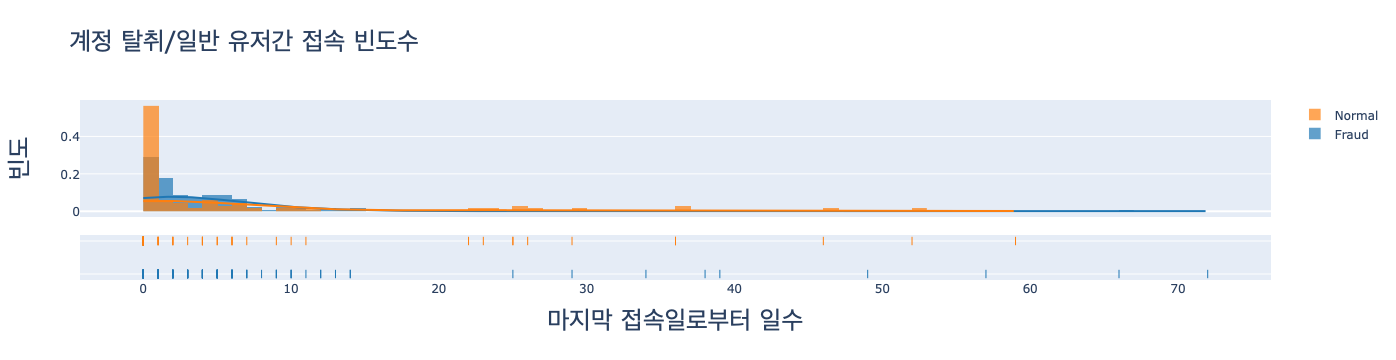

In [ ]:
import plotly.figure_factory as ff

hist_data = [
    pd.Series(data_time_diffs['fraud']).dropna().tolist(), # [0, 5, 3, 1, 3, ...]
    pd.Series(data_time_diffs['normal']).dropna().tolist() # [1, 5, 2, 3, 5, 1, ...]
]

group_labels = ['Fraud', 'Normal']

fig = ff.create_distplot(hist_data, group_labels, bin_size=1)
fig.update_layout(
    title=dict(
        text=f'계정 탈취/일반 유저간 접속 빈도수',
        font=dict(size=25),
    ),
    xaxis_title=dict(
        text="마지막 접속일로부터 일수",
        font=dict(size=25),
    ),
    yaxis_title=dict(
        text="빈도",
        font=dict(size=25),
    ),
)
fig.show()

> ##### a) 일반 유저들의 사용 빈도수가 탈취된 계정보다 빈번한 형태를 보임
> ##### b) 장기 미접속 계정의 접속시 계정 탈취를 의심해볼 수 있음

### · 중요변수 탐색
---
- 데이터 셋의 크기로 인한 실행시간 이슈로 일부 샘플 데이터만 분석

In [ ]:
%%time

column = 'Is Account Takeover'
is_true = True
num_samples = 10
filepath = CACHE_PATH / f'data_{column}_{is_true}_num_samples_{num_samples}.pkl'

if os.path.exists(filepath) :
    data_sample_taken = read_pickle(filepath)
else :
    data_sample_taken = (
        data
        .loc[lambda x : x['Is Account Takeover']==is_true, 'User ID']
        .compute()
        .sample(num_samples)
    )
    save_pickle(data_sample_taken, filepath)

CPU times: user 4.15 ms, sys: 2.43 ms, total: 6.58 ms
Wall time: 4.01 ms


In [ ]:
data_sample_taken

82947    -7654599524478640403
73039      341307978064584872
54775      866176531291139058
208509   -7840577200914229291
57116     -633849907420391782
147820    5069369253943453141
197929    -446479977368476662
49220    -4923652038968109383
217590      85128405919656256
36180     8394274651297033896
Name: User ID, dtype: int64

In [ ]:
%%time

column = 'Is Account Takeover'
is_true = False
num_samples = 100
filepath = CACHE_PATH / f'data_{column}_{is_true}_num_samples_{num_samples}.pkl'

if os.path.exists(filepath) :
    data_sample_not_taken = read_pickle(filepath)
else :
    data_sample_not_taken = (
        data
        .loc[lambda x : x['Is Account Takeover']==is_true, 'User ID']
        .sample(frac=num_samples/data_shape[0], replace=True)
        .compute()
    )
    save_pickle(data_sample_not_taken, filepath)

CPU times: user 1.47 ms, sys: 2.07 ms, total: 3.54 ms
Wall time: 3.68 ms


In [ ]:
data_sample_not_taken = data_sample_not_taken[:10]
data_sample_not_taken

76320      406160514995663359
132415    7497251758438246693
66283      317844465798242945
111553    6472807217263858531
22783      858220319712018805
141300   -4324475583306591935
115257   -4324475583306591935
30068    -1172905746566604269
37021    -4324475583306591935
138788   -6774470080900886295
Name: User ID, dtype: int64

In [ ]:
%%time

from tqdm import tqdm

user_ids_account_taken = data_sample_taken.tolist()

user_ids_account_not_taken = data_sample_not_taken.tolist()

filepath = CACHE_PATH / f'data_account_samples_visualize.pkl'

if os.path.exists(filepath) :
    data_accounts = read_pickle(filepath)
else :
    data_accounts = {}

    for user_id in tqdm(user_ids_account_taken + user_ids_account_not_taken) :
        data_accounts[user_id] = (
            data
            .loc[lambda x : x['User ID']==user_id]
            .compute()
        )
    save_pickle(data_accounts, filepath)

CPU times: user 3.32 s, sys: 1.97 s, total: 5.29 s
Wall time: 5.29 s


In [ ]:
num_samples = 500
filepath = CACHE_PATH / f'data_account_samples_visualize_sampled_{num_samples}.pkl'

if os.path.exists(filepath) :
    data = read_pickle(filepath)

else :
    data = None

    for user_id in user_ids_account_taken :
        data_chunk = (
            data_accounts[user_id]
            .assign(**{'Is Account Takeover':True})
            .sample(num_samples, replace=True)
        )
        if data is None :
            data = data_chunk
        else :
            data = pd.concat([data, data_chunk], axis=0)

    for user_id in user_ids_account_not_taken :
        data_chunk = (
            data_accounts[user_id]
            .assign(**{'Is Account Takeover':False})
            .sample(num_samples, replace=True)
        )

        data = pd.concat([data, data_chunk], axis=0)

    save_pickle(data, filepath)

In [ ]:
del data_accounts

In [ ]:
data.shape

(10000, 16)

In [ ]:
(
    data.nunique()
    .to_frame()
)

0
index                     1739
Login Timestamp           1739
User ID                     18
Round-Trip Time [ms]        31
IP Address                1289
Country                     63
Region                     179
City                       344
ASN                        237
User Agent String          919
Browser Name and Version   222
OS Name and Version         69
Device Type                  5
Login Successful             2
Is Attack IP                 2
Is Account Takeover          2

In [ ]:
(
    pd.DataFrame(
        [(column, data[column].unique().shape[0], data[column].dtype) for column in data.columns],
        columns=['column_name', 'number_of_unique_values', 'dtype']
    )
    .sort_values(by='number_of_unique_values')
)

column_name  number_of_unique_values    dtype
13          Login Successful                        2     bool
14              Is Attack IP                        2     bool
15       Is Account Takeover                        2     bool
12               Device Type                        5   object
2                    User ID                       18    int64
3       Round-Trip Time [ms]                       32  float64
5                    Country                       63   object
11       OS Name and Version                       69   object
6                     Region                      180   object
10  Browser Name and Version                      222   object
8                        ASN                      237    int64
7                       City                      345   object
9          User Agent String                      919   object
4                 IP Address                     1289   object
0                      index                     1739    int64
1            Login Timestamp                     1739   object

In [ ]:
features_to_exclude = [
    'Login Timestamp',
    'Is Account Takeover',
    'index',
    'User ID',
    'ASN'
]

features_to_investigate = (
    pd.DataFrame(
        [(column, data[column].unique().shape[0], data[column].dtype) for column in data.columns],
        columns=['column_name', 'number_of_unique_values', 'dtype']
    )
    .sort_values(by='number_of_unique_values')
    .loc[lambda x : ~x['column_name'].isin(features_to_exclude)]
    ['column_name'].tolist()
)
features_to_investigate

['Login Successful',
 'Is Attack IP',
 'Device Type',
 'Round-Trip Time [ms]',
 'Country',
 'OS Name and Version',
 'Region',
 'Browser Name and Version',
 'City',
 'User Agent String',
 'IP Address']

In [ ]:
categorical_features_to_investigate = (
    data
    .loc[:, features_to_investigate]
    .select_dtypes('object')
    .columns
    .tolist()
)
categorical_features_to_investigate

['Device Type',
 'Country',
 'OS Name and Version',
 'Region',
 'Browser Name and Version',
 'City',
 'User Agent String',
 'IP Address']

In [ ]:
numerical_features_to_investigate = (
    data
    .loc[:, features_to_investigate]
    .select_dtypes('number')
    .columns
    .tolist()
)
numerical_features_to_investigate

['Round-Trip Time [ms]']

#### (1) Categorical values

##### a) Distribution check

In [ ]:
(
    data
    .loc[:, categorical_features_to_investigate]
    .select_dtypes('object')
)

Device Type Country OS Name and Version     Region  \
20370      desktop      RO    Mac OS X 10.14.6      Ilfov   
87599      desktop      RO    Mac OS X 10.14.6          -   
51075      desktop      RO    Mac OS X 10.14.6      Ilfov   
209352     desktop      RO    Mac OS X 10.14.6          -   
164557     desktop      NG    Mac OS X 10.14.6    Adamawa   
...            ...     ...                 ...        ...   
138613      mobile      NO          iOS 11.2.6  Innlandet   
155695     desktop      NO    Mac OS X 10.12.3  Innlandet   
155695     desktop      NO    Mac OS X 10.12.3  Innlandet   
138613      mobile      NO          iOS 11.2.6  Innlandet   
138788      mobile      NO          iOS 11.2.6  Innlandet   

        Browser Name and Version          City  \
20370   Chrome 79.0.3945.192.218  Petrachioaia   
87599   Chrome 79.0.3945.192.218             -   
51075   Chrome 79.0.3945.192.218  Petrachioaia   
209352  Chrome 79.0.3945.192.205             -   
164557  Chrome 79.0.3945.192.205          Yola   
...                          ...           ...   
138613   Chrome Mobile 81.0.4044         Valer   
155695       Chrome 69.0.3497.16    Heradsbygd   
155695       Chrome 69.0.3497.16    Heradsbygd   
138613   Chrome Mobile 81.0.4044         Valer   
138788   Chrome Mobile 81.0.4044         Valer   

                                        User Agent String      IP Address  
20370   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   91.240.236.92  
87599   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...    5.180.170.68  
51075   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...  91.240.236.249  
209352  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...    5.180.170.25  
164557  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   41.223.137.14  
...                                                   ...             ...  
138613  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...      10.3.58.34  
155695  Mozilla/5.0  (Macintosh; Intel Mac OS X 10_12_...   95.169.38.203  
155695  Mozilla/5.0  (Macintosh; Intel Mac OS X 10_12_...   95.169.38.203  
138613  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...      10.3.58.34  
138788  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...      10.3.58.34  

[10000 rows x 8 columns]

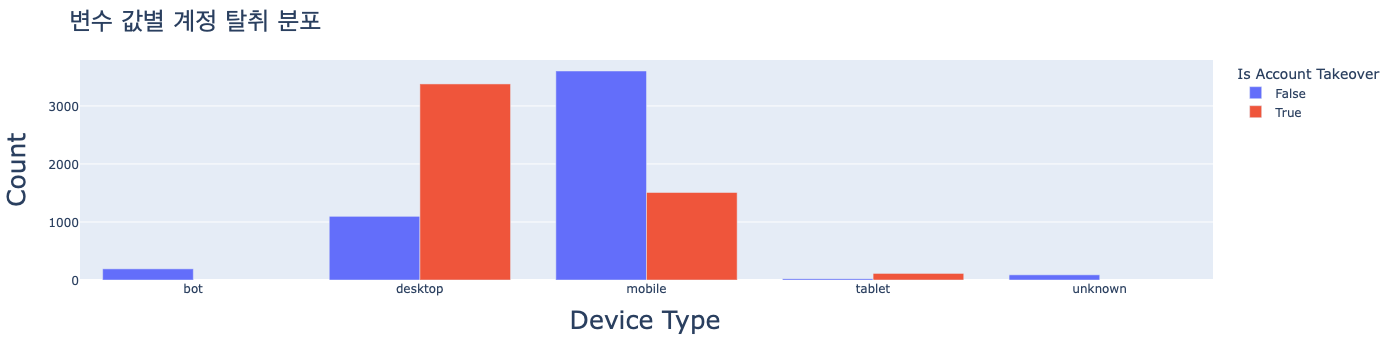

Device Type  Is Account Takeover  Count
7     unknown                False     89
5      tablet                 True    113
6      tablet                False     20
4      mobile                 True   1508
3      mobile                False   3602
1     desktop                 True   3379
2     desktop                False   1097
0         bot                False    192

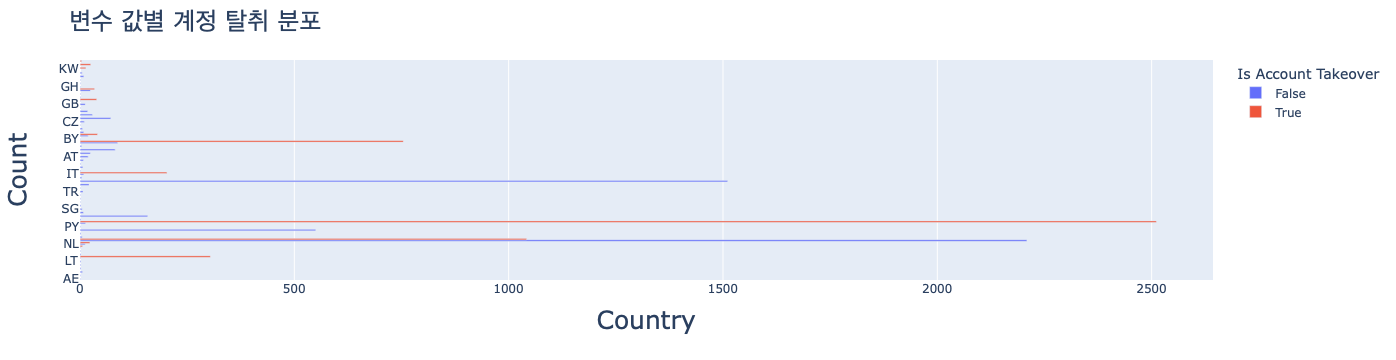

Country  Is Account Takeover  Count
72      ZM                False      1
71      ZA                False      6
70      VN                False      4
69      US                False   1511
68      UA                False     21
..     ...                  ...    ...
4       BD                False     82
3       AU                False     24
2       AT                False     19
1       AR                False      8
0       AE                False      1

[73 rows x 3 columns]

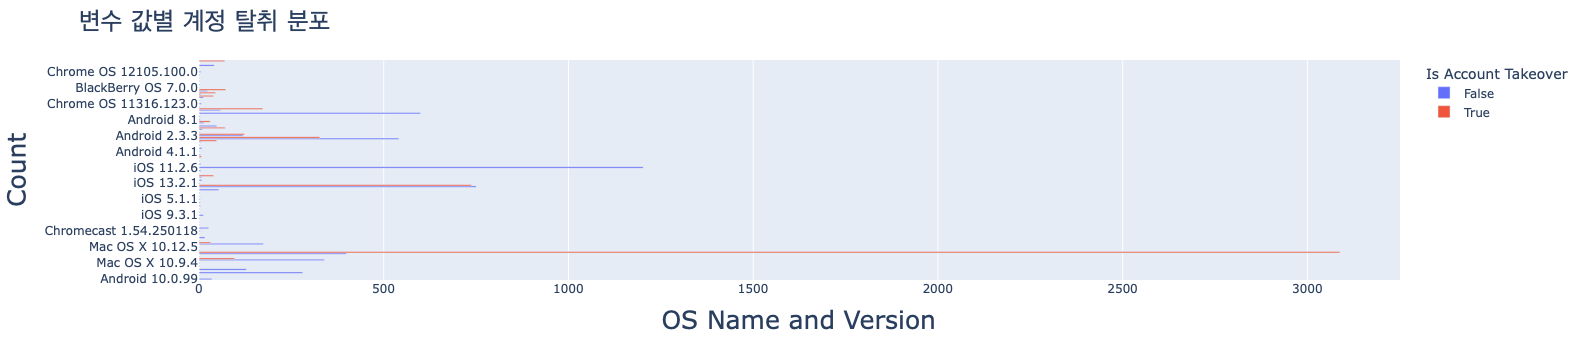

OS Name and Version  Is Account Takeover  Count
83           iOS 9.3.4                False      4
82           iOS 9.3.3                False      2
81           iOS 9.3.1                False     12
80           iOS 9.0.2                False      2
79             iOS 8.2                False      1
..                 ...                  ...    ...
4          Android 2.0                False      1
2         Android 13.0                 True     73
3         Android 13.0                False     23
1         Android 12.0                False      1
0      Android 10.0.99                False     35

[84 rows x 3 columns]

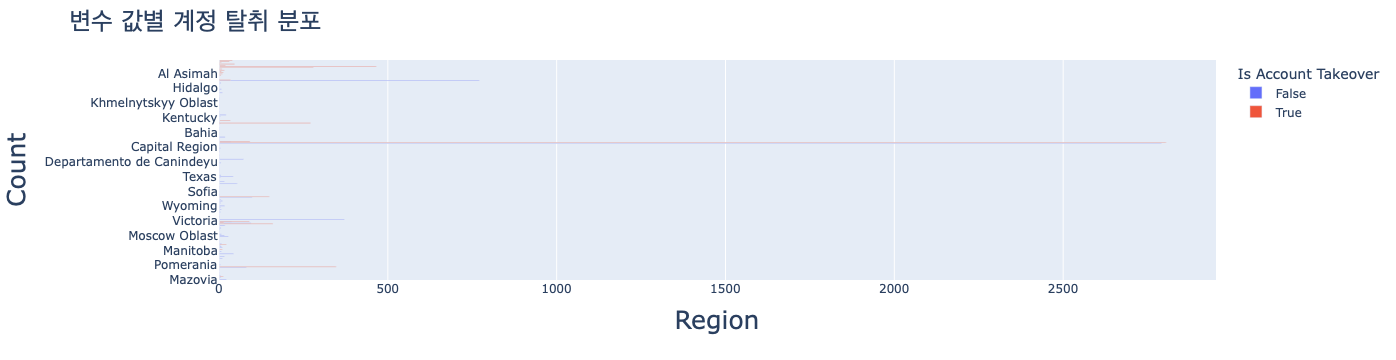

Region  Is Account Takeover  Count
191       Świętokrzyskie                False      1
190     Łódź Voivodeship                False     10
189               Zurich                False      4
188              Zeeland                 True     10
187  Zaporizhzhya Oblast                False      1
..                   ...                  ...    ...
3                  Agder                 True     92
4                  Agder                False     35
2                Adamawa                 True      6
0                      -                 True   2805
1                      -                False   2792

[192 rows x 3 columns]

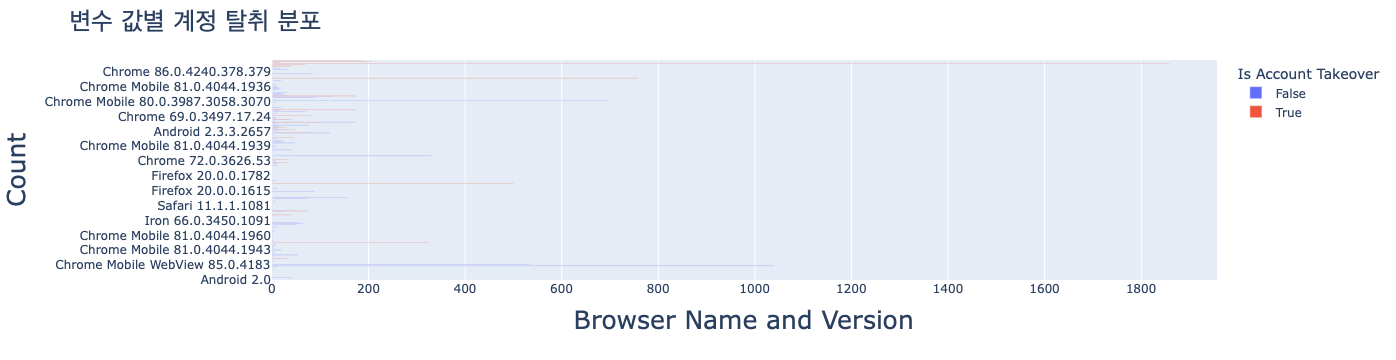

Browser Name and Version  Is Account Takeover  Count
241           startmebot 1.0                False     32
240             okhttp 3.8.1                False      1
239            ZipppBot 0.11                False    156
238            VLC 3.0.0-git                False     74
237        UC Browser 13.1.8                False      1
..                       ...                  ...    ...
4         Android 2.2.2.2633                False      1
3              Android 2.2.2                False      4
2         Android 2.0.0.2423                 True     40
1         Android 2.0.0.2416                False      1
0                Android 2.0                False      1

[242 rows x 3 columns]

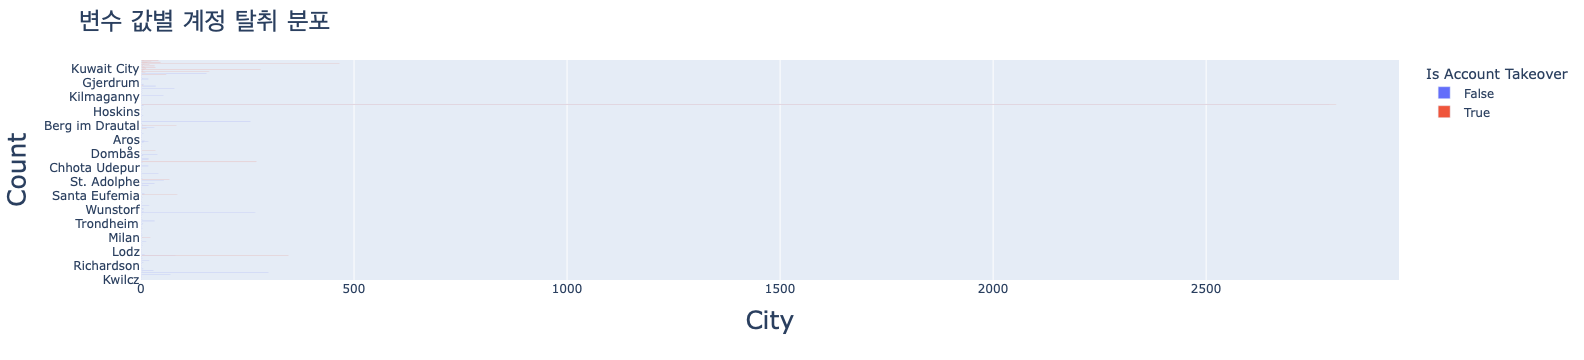

City  Is Account Takeover  Count
354     Ålesund                False      1
353      Zurich                False      4
352  Ziesendorf                False      7
351    Zelechow                False      1
350        Yola                 True      6
..          ...                  ...    ...
4      Akrehamn                False      1
3        Airoli                False      1
2         Accra                False      1
0             -                 True   2805
1             -                False   2790

[355 rows x 3 columns]

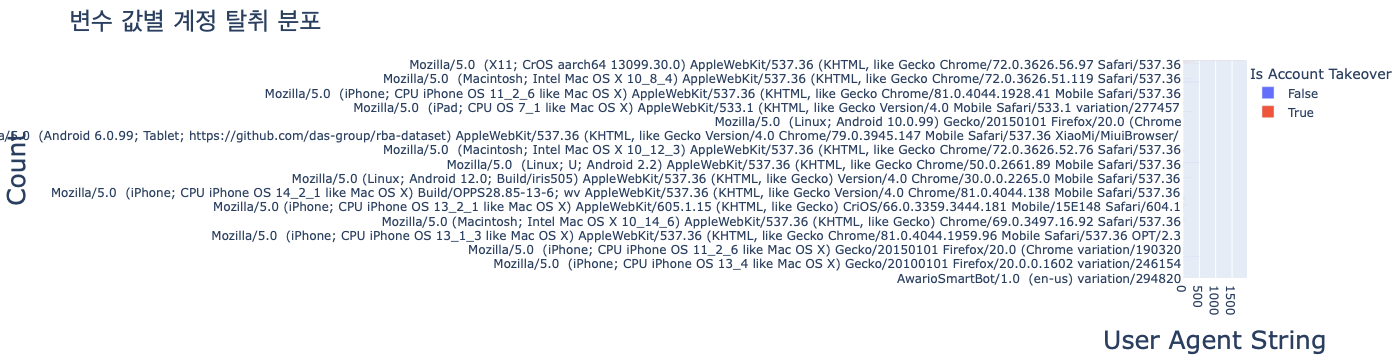

User Agent String  Is Account Takeover  \
930                                       okhttp/3.8.1                False   
929                            dloader(NaverRobot)/1.0                False   
928  ZoomBot (Linkbot 1.0 https://github.com/das-gr...                False   
927  ZipppBot/0.11 (ZipppBot; https://github.com/da...                False   
926  ZipppBot/0.11 (ZipppBot; https://github.com/da...                False   
..                                                 ...                  ...   
4    AwarioSmartBot/1.0  (iPhone; CPU iPhone OS 13_...                False   
3         AwarioSmartBot/1.0  (en-us) variation/294825                False   
2         AwarioSmartBot/1.0  (en-us) variation/294822                False   
1         AwarioSmartBot/1.0  (en-us) variation/294821                False   
0         AwarioSmartBot/1.0  (en-us) variation/294820                False   

     Count  
930      1  
929      1  
928      2  
927     14  
926    142  
..     ...  
4        1  
3        1  
2        2  
1        4  
0        6  

[931 rows x 3 columns]

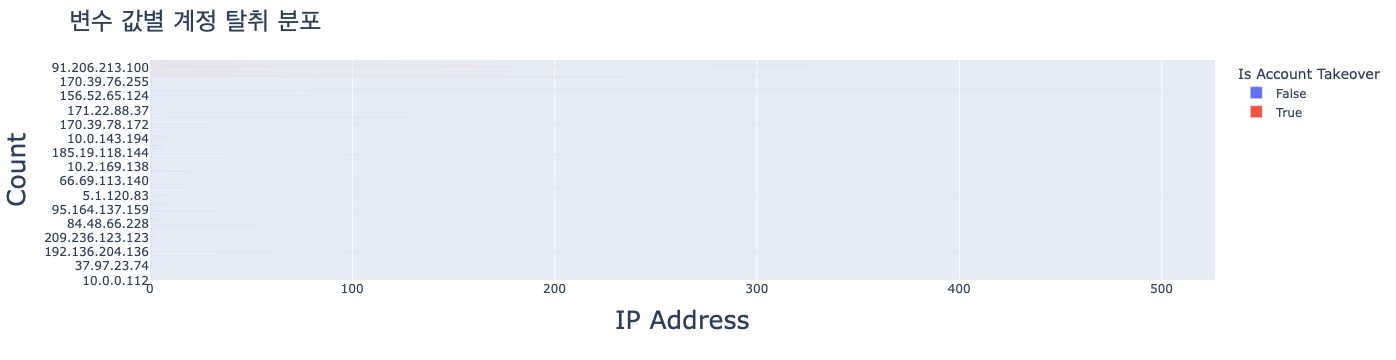

IP Address  Is Account Takeover  Count
1288  97.105.212.34                False      1
1287   95.81.135.29                False      1
1286  95.81.135.162                False      1
1285  95.81.134.125                False      1
1284   95.169.51.56                False      1
...             ...                  ...    ...
4        10.0.0.154                False      1
3        10.0.0.145                False      1
2        10.0.0.120                False      1
1        10.0.0.114                False      1
0        10.0.0.112                False      1

[1289 rows x 3 columns]

In [ ]:
for column in categorical_features_to_investigate :
    data_toplot = (
        data
        .groupby(column)
        ['Is Account Takeover']
        .value_counts()
        .to_frame()
        .rename(columns={'Is Account Takeover':'Count'})
        .reset_index(drop=False)
        .sort_values(by='Is Account Takeover')
    )

    if data_toplot[column].unique().shape[0] < 10 :
        fig = px.bar(data_toplot, x=column, y='Count', color='Is Account Takeover', barmode='group')
    else :
        fig = px.bar(data_toplot, x='Count', y=column, color='Is Account Takeover', barmode='group', orientation='h')
    fig.update_layout(
        title=dict(
            text='변수 값별 계정 탈취 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
    fig.show()
    display(data_toplot.sort_values(by=[column, 'Is Account Takeover'], ascending=False))

#### (1) Numerical values
##### a) Correlation

In [ ]:
(
    data
    .loc[:, numerical_features_to_investigate]
    .select_dtypes('number')
)

Round-Trip Time [ms]
20370                    NaN
87599                    NaN
51075                    NaN
209352                   NaN
164557                   NaN
...                      ...
138613                   NaN
155695                   NaN
155695                   NaN
138613                   NaN
138788                   NaN

[10000 rows x 1 columns]

In [ ]:
(
    pd.concat(
        [
            (
                data
                .loc[:, numerical_features_to_investigate]
                .select_dtypes('number')
            ),
            (
                data['Is Account Takeover']
            ),
        ],
        axis=1
    )
)

Round-Trip Time [ms]  Is Account Takeover
20370                    NaN                 True
87599                    NaN                 True
51075                    NaN                 True
209352                   NaN                 True
164557                   NaN                 True
...                      ...                  ...
138613                   NaN                False
155695                   NaN                False
155695                   NaN                False
138613                   NaN                False
138788                   NaN                False

[10000 rows x 2 columns]

In [ ]:
(
    pd.concat(
        [
            (
                data
                .loc[:, numerical_features_to_investigate]
                .select_dtypes('number')
            ),
            (
                data['Is Account Takeover']
            ),
        ],
        axis=1
    )
    .corr()
    .style.background_gradient()
)

# **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature (X)와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
data.iloc[:4].T

20370   \
index                                                               4735575   
Login Timestamp                                     2020-04-07 18:04:22.764   
User ID                                                -7654599524478640403   
Round-Trip Time [ms]                                                    NaN   
IP Address                                                    91.240.236.92   
Country                                                                  RO   
Region                                                                Ilfov   
City                                                           Petrachioaia   
ASN                                                                   62350   
User Agent String         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
Browser Name and Version                           Chrome 79.0.3945.192.218   
OS Name and Version                                        Mac OS X 10.14.6   
Device Type                                                         desktop   
Login Successful                                                       True   
Is Attack IP                                                           True   
Is Account Takeover                                                    True   

                                                                     87599   \
index                                                              14089421   
Login Timestamp                                     2020-08-18 04:21:14.663   
User ID                                                -7654599524478640403   
Round-Trip Time [ms]                                                    NaN   
IP Address                                                     5.180.170.68   
Country                                                                  RO   
Region                                                                    -   
City                                                                      -   
ASN                                                                  206801   
User Agent String         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
Browser Name and Version                           Chrome 79.0.3945.192.218   
OS Name and Version                                        Mac OS X 10.14.6   
Device Type                                                         desktop   
Login Successful                                                       True   
Is Attack IP                                                           True   
Is Account Takeover                                                    True   

                                                                     51075   \
index                                                              14927444   
Login Timestamp                                     2020-08-29 10:36:46.184   
User ID                                                -7654599524478640403   
Round-Trip Time [ms]                                                    NaN   
IP Address                                                   91.240.236.249   
Country                                                                  RO   
Region                                                                Ilfov   
City                                                           Petrachioaia   
ASN                                                                   62350   
User Agent String         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
Browser Name and Version                           Chrome 79.0.3945.192.218   
OS Name and Version                                        Mac OS X 10.14.6   
Device Type                                                         desktop   
Login Successful                                                       True   
Is Attack IP                                                           True   
Is Account Takeover                                                    True   

                                     

In [ ]:
data.iloc[:4].loc[:, features_to_investigate].T

20370   \
Login Successful                                                       True   
Is Attack IP                                                           True   
Device Type                                                         desktop   
Round-Trip Time [ms]                                                    NaN   
Country                                                                  RO   
OS Name and Version                                        Mac OS X 10.14.6   
Region                                                                Ilfov   
Browser Name and Version                           Chrome 79.0.3945.192.218   
City                                                           Petrachioaia   
User Agent String         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
IP Address                                                    91.240.236.92   

                                                                     87599   \
Login Successful                                                       True   
Is Attack IP                                                           True   
Device Type                                                         desktop   
Round-Trip Time [ms]                                                    NaN   
Country                                                                  RO   
OS Name and Version                                        Mac OS X 10.14.6   
Region                                                                    -   
Browser Name and Version                           Chrome 79.0.3945.192.218   
City                                                                      -   
User Agent String         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
IP Address                                                     5.180.170.68   

                                                                     51075   \
Login Successful                                                       True   
Is Attack IP                                                           True   
Device Type                                                         desktop   
Round-Trip Time [ms]                                                    NaN   
Country                                                                  RO   
OS Name and Version                                        Mac OS X 10.14.6   
Region                                                                Ilfov   
Browser Name and Version                           Chrome 79.0.3945.192.218   
City                                                           Petrachioaia   
User Agent String         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
IP Address                                                   91.240.236.249   

                                                                     209352  
Login Successful                                                       True  
Is Attack IP                                                           True  
Device Type                                                         desktop  
Round-Trip Time [ms]                                                    NaN  
Country                                                                  RO  
OS Name and Version                                        Mac OS X 10.14.6  
Region                                                                    -  
Browser Name and Version                           Chrome 79.0.3945.192.205  
City                                                                      -  
User Agent String         Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...  
IP Address                                                     5.180.170.25

In [ ]:
dataset = data.loc[:, features_to_investigate + ['Is Account Takeover']]
dataset

Login Successful  Is Attack IP Device Type  Round-Trip Time [ms]  \
20370               True          True     desktop                   NaN   
87599               True          True     desktop                   NaN   
51075               True          True     desktop                   NaN   
209352              True          True     desktop                   NaN   
164557              True         False     desktop                   NaN   
...                  ...           ...         ...                   ...   
138613             False         False      mobile                   NaN   
155695              True         False     desktop                   NaN   
155695              True         False     desktop                   NaN   
138613             False         False      mobile                   NaN   
138788             False         False      mobile                   NaN   

       Country OS Name and Version     Region  Browser Name and Version  \
20370       RO    Mac OS X 10.14.6      Ilfov  Chrome 79.0.3945.192.218   
87599       RO    Mac OS X 10.14.6          -  Chrome 79.0.3945.192.218   
51075       RO    Mac OS X 10.14.6      Ilfov  Chrome 79.0.3945.192.218   
209352      RO    Mac OS X 10.14.6          -  Chrome 79.0.3945.192.205   
164557      NG    Mac OS X 10.14.6    Adamawa  Chrome 79.0.3945.192.205   
...        ...                 ...        ...                       ...   
138613      NO          iOS 11.2.6  Innlandet   Chrome Mobile 81.0.4044   
155695      NO    Mac OS X 10.12.3  Innlandet       Chrome 69.0.3497.16   
155695      NO    Mac OS X 10.12.3  Innlandet       Chrome 69.0.3497.16   
138613      NO          iOS 11.2.6  Innlandet   Chrome Mobile 81.0.4044   
138788      NO          iOS 11.2.6  Innlandet   Chrome Mobile 81.0.4044   

                City                                  User Agent String  \
20370   Petrachioaia  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
87599              -  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
51075   Petrachioaia  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
209352             -  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
164557          Yola  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
...              ...                                                ...   
138613         Valer  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   
155695    Heradsbygd  Mozilla/5.0  (Macintosh; Intel Mac OS X 10_12_...   
155695    Heradsbygd  Mozilla/5.0  (Macintosh; Intel Mac OS X 10_12_...   
138613         Valer  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   
138788         Valer  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   

            IP Address  Is Account Takeover  
20370    91.240.236.92                 True  
87599     5.180.170.68                 True  
51075   91.240.236.249                 True  
209352    5.180.170.25                 True  
164557   41.223.137.14                 True  
...                ...                  ...  
138613      10.3.58.34                False  
155695   95.169.38.203                False  
155695   95.169.38.203                False  
138613      10.3.58.34                False  
138788      10.3.58.34                False  

[10000 rows x 12 columns]

In [ ]:
categorical_features = categorical_features_to_investigate
numerical_features = numerical_features_to_investigate
target_value='Is Account Takeover'

In [ ]:
categorical_features

['Device Type',
 'Country',
 'OS Name and Version',
 'Region',
 'Browser Name and Version',
 'City',
 'User Agent String',
 'IP Address']

In [ ]:
numerical_features

['Round-Trip Time [ms]']

In [ ]:
target_value

'Is Account Takeover'

### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가
* 참고 자료
    - [Pycaret:Classification](https://pycaret.readthedocs.io/en/stable/api/classification.html)
    


#### 1) 모델 학습

![](figures/16_5.png)

- 과거에는 Scikit-learn, Pytorch등의 패키지등을 통해 모델과 전/후처리 파이프라인들을 개별적으로 설정하여 모델 비교를 위한 실험 코드를 작성
- 여러 프로젝트에서 동일한 코드를 반복적으로 작성/사용하게 되며 이로 인한 효율이 떨어짐
- 이미 알려지고 사용되고 있는 모델들을 한꺼번에 실험할수 있는 인터페이스가 필요 -> `Pycaret` 활용하여 빠르게 여러 모델간의 성능 비교가 가능

In [ ]:
!pip install pycaret==3.0.0rc4


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from pycaret.classification import ClassificationExperiment

experiment_name = 'chapter_18'
exp = ClassificationExperiment()

- 실험 수행

In [ ]:
exp.setup(
    data=dataset.sample(2000),
    target=target_value,
    train_size=0.8,
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    normalize=True,
    fold_strategy='kfold',
    fold_shuffle=True,
    fold=5,
    experiment_name=experiment_name
)

- 실험 결과 확인
    - AUC, Recall, Prec.(Precision) 확인

In [ ]:
models = exp.compare_models(sort='AUC', n_select=5)

[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.


#### 2) 모델 평가

- Logistic Regression

![](figures/18_4.png)

In [ ]:
model = models[0]

##### a) Confusion matrix
![](figures/16_3.png)

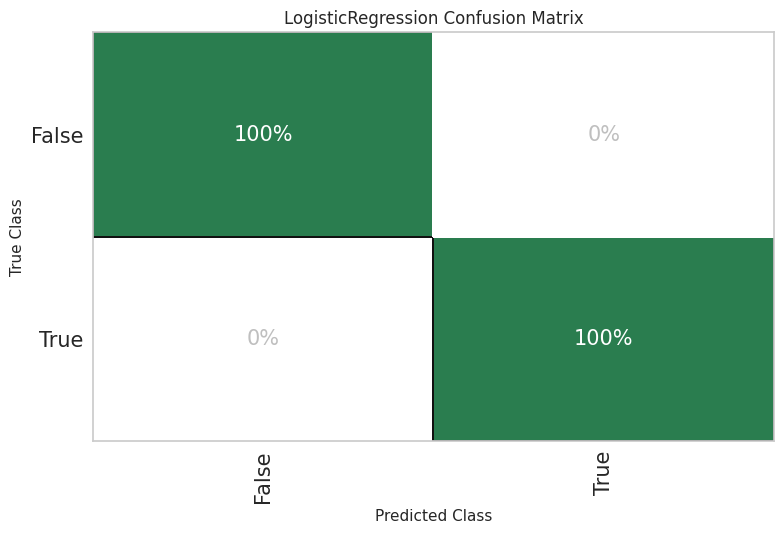

In [ ]:
exp.plot_model(model, plot='confusion_matrix', plot_kwargs={'percent':True})

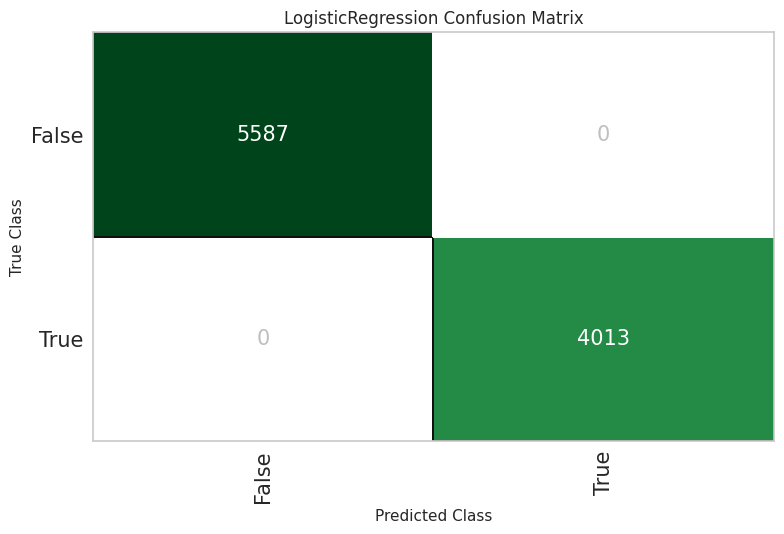

In [ ]:
exp.plot_model(model, plot='confusion_matrix')

##### b) AUROC

![](figures/16_2.png)
![](figures/16_4.png)

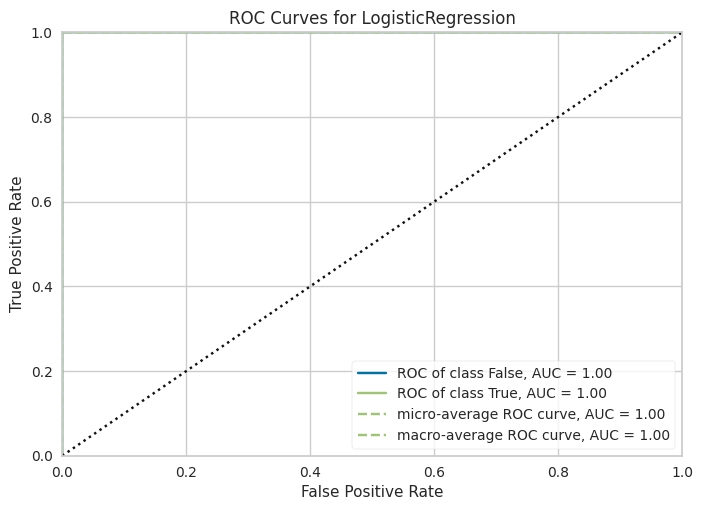

In [ ]:
exp.plot_model(model, plot='auc')

#### 2) 모델 해석

##### a) 모델 Threshold

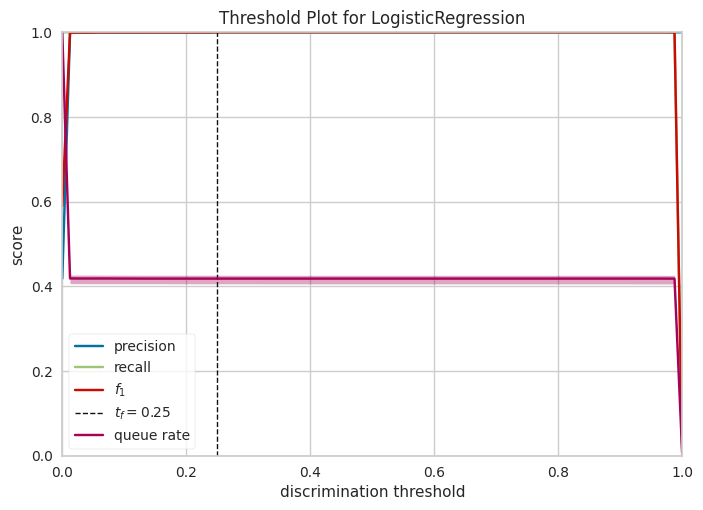

In [ ]:
exp.plot_model(model, plot='threshold')

##### b) 모델 Training history

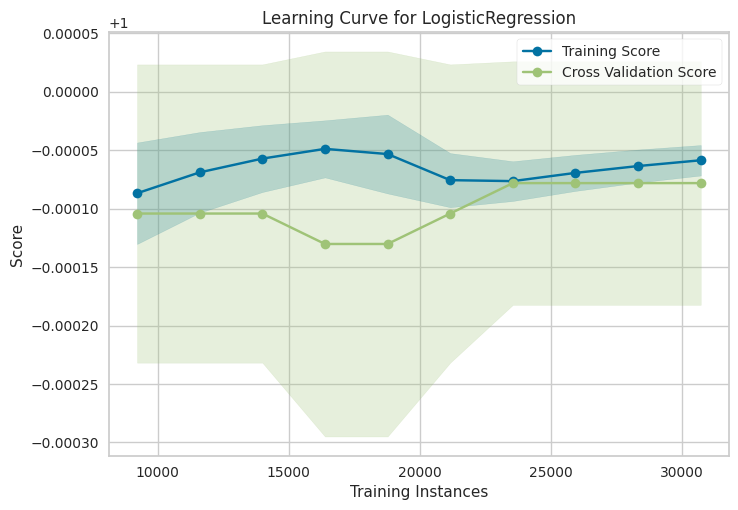

In [ ]:
exp.plot_model(model, plot='learning')

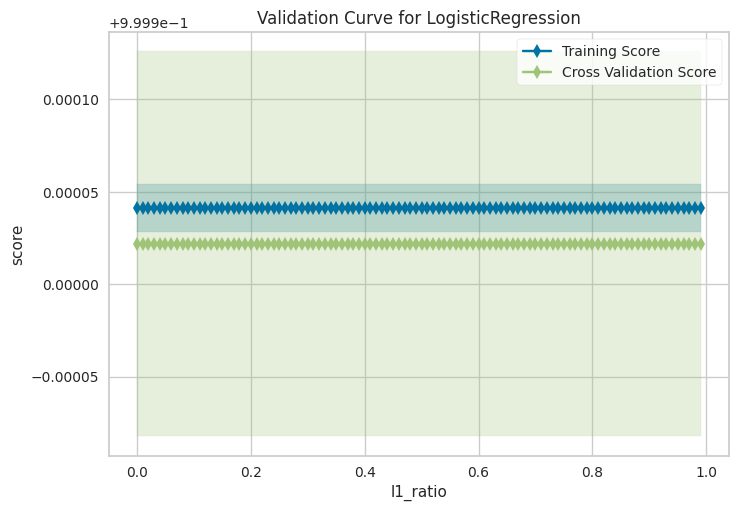

In [ ]:
exp.plot_model(model, plot='vc')

##### c) 모델 Decision boundary 시각화
![](figures/16_6.png)

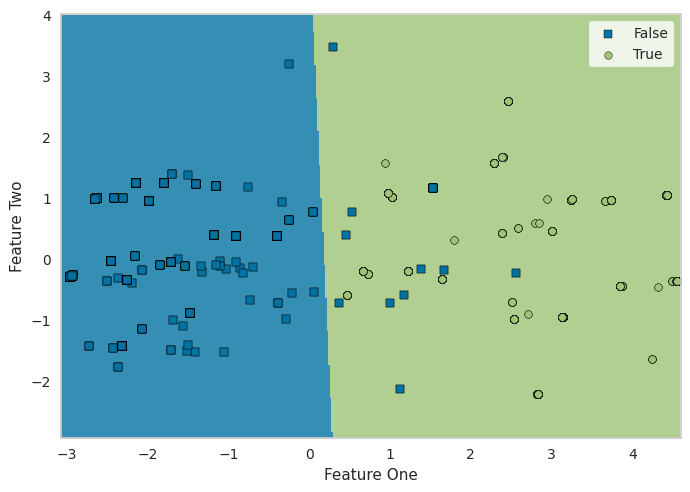

In [ ]:
exp.plot_model(model, plot='boundary')

### · 중요 변수 파악
---
* Feature importance 분석을 통한 중요변수 파악


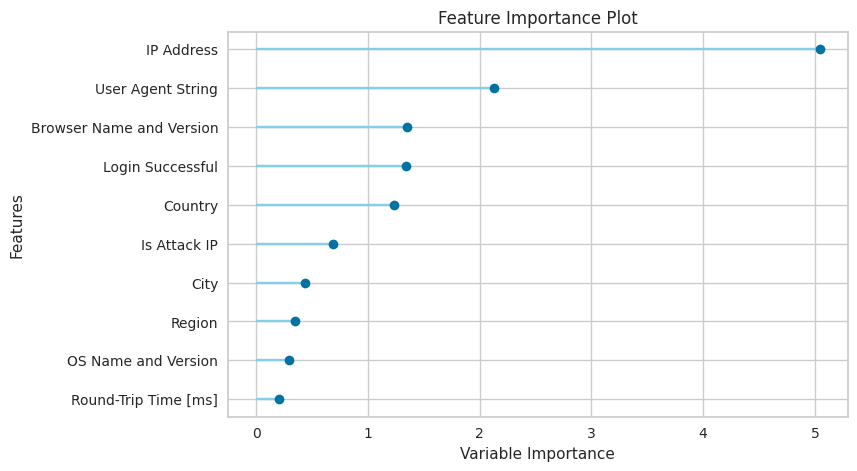

In [ ]:
exp.plot_model(model, plot='feature')

- RFE (Recursive feature elimiation)

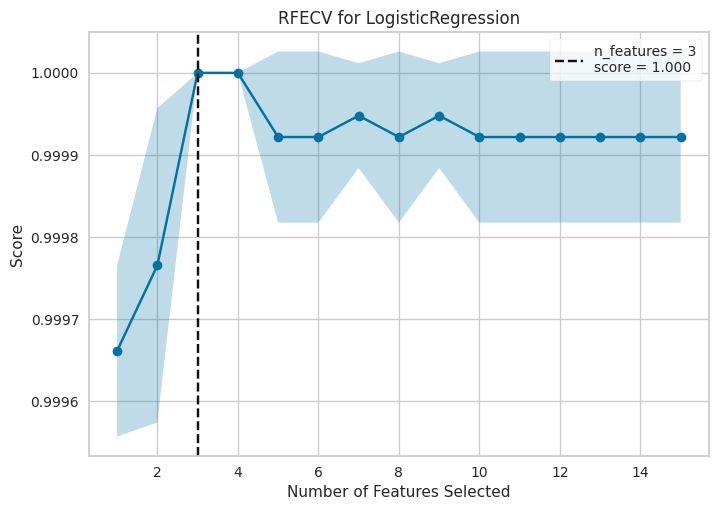

In [ ]:
exp.plot_model(model, plot='rfe')


### · 모델 확인
---
* 실험으로부터 사용할 수 있는 모델을 불러오기

In [ ]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7735, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model_finalized = exp.finalize_model(model)

In [ ]:
x_test = exp.X_test
x_test

Login Successful  Is Attack IP Device Type  Round-Trip Time [ms]  \
38396             False          True      mobile                   NaN   
38397              True         False      mobile                   NaN   
38398              True         False      mobile                   NaN   
38399              True         False     desktop                   NaN   
38400             False          True      mobile                   NaN   
...                 ...           ...         ...                   ...   
47991             False          True      mobile                   NaN   
47992              True         False      mobile                   NaN   
47993              True          True      mobile                   NaN   
47994              True          True     desktop                   NaN   
47995              True         False      mobile                   NaN   

      Country OS Name and Version  Region         Browser Name and Version  \
38396      US         Android 4.1       -  Chrome Mobile WebView 81.0.4044   
38397      NO            iOS 13.4       -  Chrome Mobile WebView 85.0.4183   
38398      NO            iOS 13.4       -  Chrome Mobile WebView 85.0.4183   
38399      LV    Mac OS X 10.14.6    Riga         Chrome 79.0.3945.192.218   
38400      US         Android 4.1       -  Chrome Mobile WebView 81.0.4044   
...       ...                 ...     ...                              ...   
47991      US         Android 4.1       -  Chrome Mobile WebView 81.0.4044   
47992      US          iOS 11.2.6       -  Chrome Mobile WebView 81.0.4044   
47993      RO       Android 5.5.1       -     Chrome Mobile 81.0.4044.1950   
47994      IT    Mac OS X 10.14.6  Veneto         Chrome 79.0.3945.192.218   
47995      US          iOS 11.2.6       -  Chrome Mobile WebView 81.0.4044   

                      City                                  User Agent String  \
38396                    -  Mozilla/5.0  (Linux; Android 4.1; Galaxy Nexus...   
38397                    -  Mozilla/5.0  (iPhone; CPU iPhone OS 13_4 like ...   
38398                    -  Mozilla/5.0  (iPhone; CPU iPhone OS 13_4 like ...   
38399                 Riga  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
38400                    -  Mozilla/5.0  (Linux; Android 4.1; Galaxy Nexus...   
...                    ...                                                ...   
47991                    -  Mozilla/5.0  (Linux; Android 4.1; Galaxy Nexus...   
47992                    -  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   
47993                    -  Mozilla/5.0 (Linux; Android 5.5.1; CHM-U01) Ap...   
47994  Altavilla Vicentina  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...   
47995                    -  Mozilla/5.0  (iPhone; CPU iPhone OS 11_2_6 lik...   

          IP Address  
38396   66.248.237.1  
38397  139.164.8.127  
38398  139.164.8.127  
38399    10.4.97.151  
38400   66.248.237.1  
...              ...  
47991   66.248.237.1  
47992  170.39.78.172  
47993    64.79.50.14  
47994      10.0.51.1  
47995   170.39.77.20  

[9600 rows x 11 columns]

In [ ]:
y_test = exp.y_test
y_test

38396    False
38397    False
38398    False
38399     True
38400    False
         ...  
47991    False
47992    False
47993     True
47994     True
47995    False
Name: Is Account Takeover, Length: 9600, dtype: bool

In [ ]:
from sklearn.metrics import roc_auc_score

yhat_test = model_finalized.predict(x_test)
roc_auc_score(yhat_test, y_test)

1.0


### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
exp.save_model(
    model=model_finalized,
    model_name=f'model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Round-Trip Time [ms]'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Device Type', 'Count...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=StandardScaler(copy=True,


In [ ]:
model_loaded = exp.load_model(
    model_name=f'model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Loaded


In [ ]:
model_loaded.predict(x_test)

array([False, False, False, ...,  True,  True, False])